<a href="https://colab.research.google.com/github/TiffPlourde/Statistical-Methods-in-ML/blob/main/Player_Ranking_Using_TrueSkill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Markov chain Monte Carlo in the TrueSkill model

The goal of this is to get familiar with the basics of Bayesian inference in medium-sized models with continuous latent variables, and the basics of Hamiltonian Monte Carlo.

# Background
We'll implement a variant of the [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2.
It is a generalization of the Elo rating system in Chess.

## Model definition
We'll consider a slightly simplified version of the original trueskill model.
We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_A - z_B)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.

In [1]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch
import random
from torch.distributions.normal import Normal

from functools import partial

import matplotlib.pyplot as plt

def diag_gaussian_log_density(x, mu, std):
  m = Normal(mu, std)
  return torch.sum(m.log_prob(x), axis=-1)

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=c6040df0ba1a7f34f6d25bc7f2ffdfe332fca7fa926c2e4927846fb92c004c16
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


Implementing a function $\texttt{log_joint_prior}$ that computes the log of the prior, jointly evaluated over all player's skills.

  Specifically, given a $K \times N$ array where each row is a setting of the skills for all $N$ players, it returns a $K \times 1$ array, where each row contains a scalar giving the log-prior for that set of skills.

In [2]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, 0, 1)

Implementing two functions $\texttt{logp_a_beats_b}$ and $\texttt{logp_b_beats_a}$.

Given a pair of skills $z_a$ and $z_b$, $\texttt{logp_a_beats_b}$ let's evaluate the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above, and $\texttt{logp_b_beats_a}$ is vice versa.

To ensure numerical stability, let's use the function $torch.logaddexp$

In [3]:
def logp_a_beats_b(z_a, z_b):
  return -torch.logaddexp(torch.tensor([0]), z_b - z_a)

def logp_b_beats_a(z_a, z_b):
  return -torch.logaddexp(torch.tensor([0]), z_a - z_b)

# Examining the posterior for only two players and toy data
To get a feel for this model, we'll first consider the case where we only have 2 players, $A$ and $B$.
We'll examine how the prior and likelihood interact when conditioning on different sets of games.

Provided in the starter code is a function $\texttt{plot_isocontours}$ which evaluates a provided function on a grid of $z_A$ and $z_B$'s and plots the isocontours of that function.
There is also a function $\texttt{plot_2d_fun}$.
We have included an example for how you can use these functions.

In [4]:
# Plotting helper functions
def plot_isocontours(ax, func, steps=100):
    x = torch.linspace(-4, 4, steps=steps)
    y = torch.linspace(-4, 4, steps=steps)
    X, Y = torch.meshgrid(x, y, indexing="ij")
    Z = func(X, Y)
    cs = plt.contour(X, Y, Z )
    plt.clabel(cs, inline=1, fontsize=10)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", scatter_pts=None):
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')
    plt.show(block=True)
    plt.draw()


For two players  A  and  B , let's plot the isocontours of the joint prior over their skills. Also plotting the line of equal skill,  zA=zB . Using the helper function plot_2d_fun above to plot.

According to the prior, the chance that player A is better than player B...

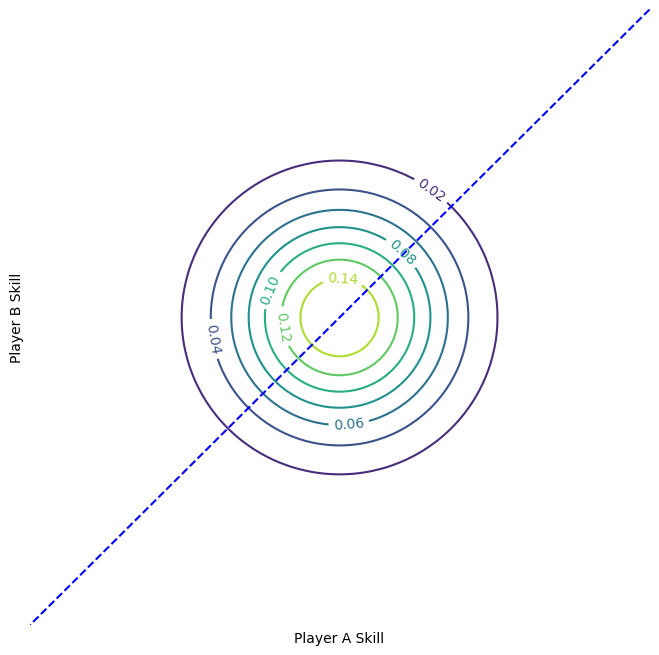

<Figure size 640x480 with 0 Axes>

In [5]:
def log_prior_over_2_players(z1, z2):
  m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
  return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
  return np.exp(log_prior_over_2_players(z1, z2))


plot_2d_fun(prior_over_2_players, "Player A Skill", "Player B Skill")

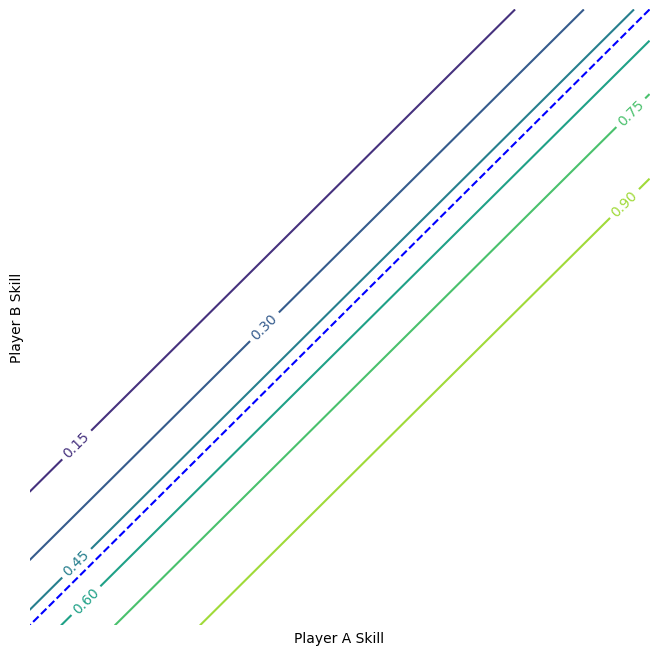

<Figure size 640x480 with 0 Axes>

In [6]:
def likelihood_over_2_players(z1, z2):
  return torch.exp(logp_a_beats_b(z1, z2))

plot_2d_fun(likelihood_over_2_players, "Player A Skill", "Player B Skill")

Plotting isocountours of the joint posterior over  zA  and  zB  given that player A beat player B in one match. Since the contours don't depend on the normalization constant, you can simply plot the isocontours of the log of joint distribution of  p(zA,zB|A beat B) . Also plotting the line of equal skill,  zA=zB .

To think about: According to this posterior, which player is likely to have higher skill?

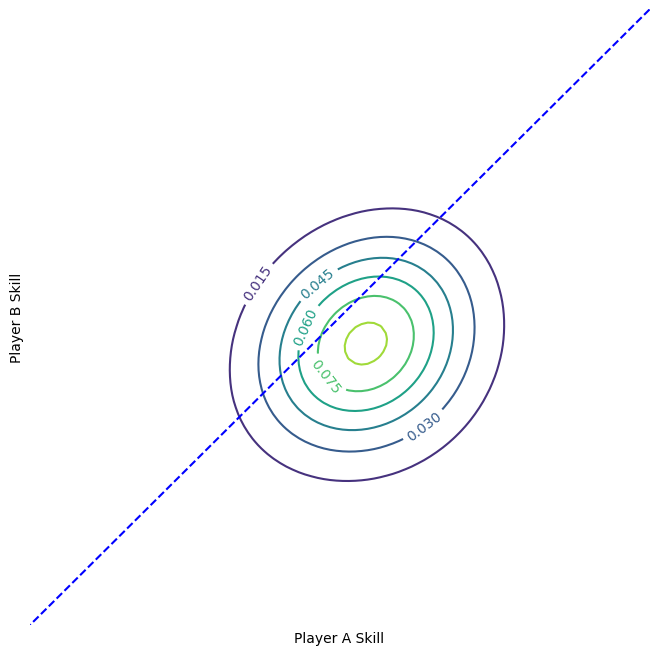

<Figure size 640x480 with 0 Axes>

In [7]:
def log_posterior_A_beat_B(z1, z2):
  return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
  return torch.exp(log_posterior_A_beat_B(z1, z2))

plot_2d_fun(posterior_A_beat_B, "Player A Skill", "Player B Skill")


Plotting isocountours of the joint posterior over  zA  and  zB  given that 5 matches were played, and player A beat player B in all matches. Also plotting the line of equal skill,  zA=zB .

To think about: According to this posterior, is it plausible that player B is more skilled than player A?

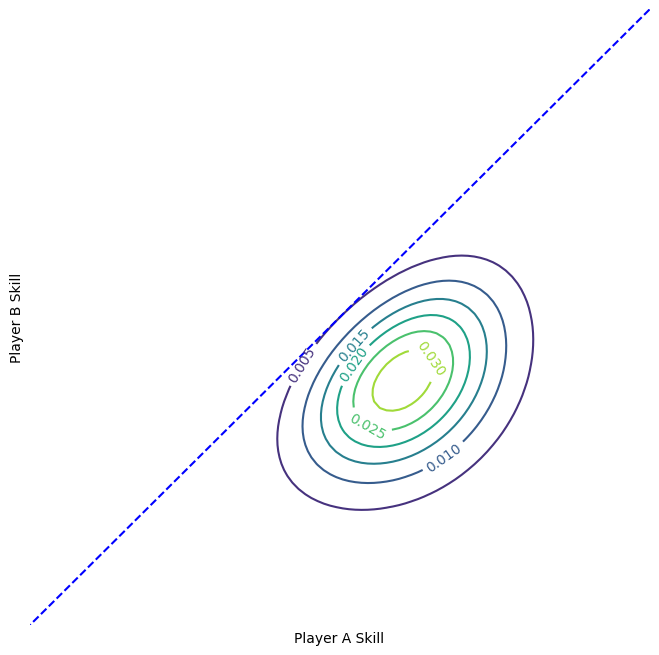

<Figure size 640x480 with 0 Axes>

In [8]:
def log_posterior_A_beat_B_5_times(z1, z2):
  return log_prior_over_2_players(z1, z2) + 5 * logp_a_beats_b(z1, z2)


def posterior_A_beat_B_5_times(z1, z2):
  return torch.exp(log_posterior_A_beat_B_5_times(z1, z2))


plot_2d_fun(posterior_A_beat_B_5_times, "Player A Skill", "Player B Skill")

Plot isocontours of the joint posterior over  zA  and  zB  given that 10 matches were played, and each player beat the other 5 times. Also plot the line of equal skill,  zA=zB .

To think about: According to this posterior, is it likely that one player is much better than another? Is it plausible that both players are better than average? Worse than average?

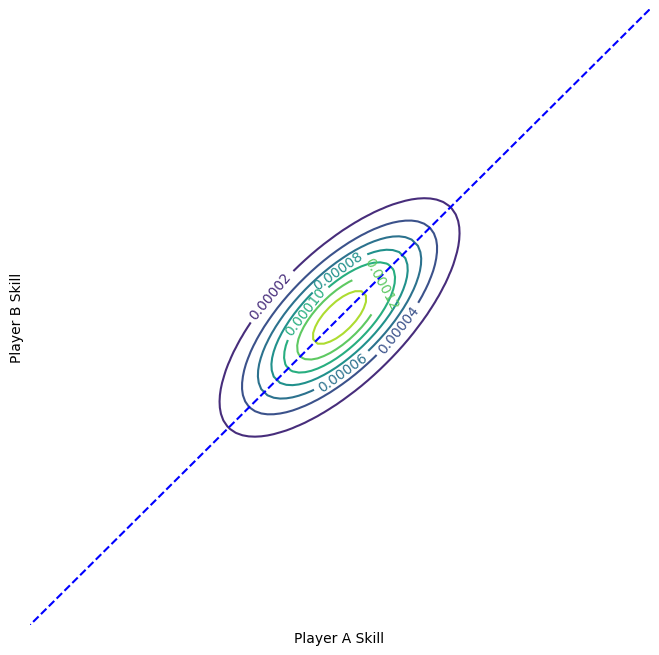

<Figure size 640x480 with 0 Axes>

In [9]:
def log_posterior_beat_each_other_5_times(z1, z2):
  # Combine the prior for two players with the likelihood for A beat B.
  # You might want to use your log_prior_over_2_players function from above.
  return log_prior_over_2_players(z1, z2) + 5 * (logp_a_beats_b(z1, z2) + logp_b_beats_a(z1, z2))


def posterior_beat_each_other_5_times(z1, z2):
  return torch.exp(log_posterior_beat_each_other_5_times(z1, z2))


plot_2d_fun(posterior_beat_each_other_5_times, "Player A Skill", "Player B Skill")

# Hamiltonian Monte Carlo on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.
Carl Rasmussen's assignment uses Gibbs sampling.

We will approximate posterior distributions with gradient-based Hamiltonian Monte Carlo.

In the next assignment, we'll use gradient-based stochastic variational inference, which wasn't invented until around 2014.

In [10]:
random.seed(42)
torch.manual_seed(42)

# Hamiltonian Monte Carlo
from tqdm import trange, tqdm_notebook  # Progress meters

def leapfrog(params_t0, momentum_t0, stepsize, logprob_grad_fun):
  # Performs a reversible update of parameters and momentum
  # See https://en.wikipedia.org/wiki/Leapfrog_integration
  momentum_thalf = momentum_t0    + 0.5 * stepsize * logprob_grad_fun(params_t0)
  params_t1 =      params_t0      +       stepsize * momentum_thalf
  momentum_t1 =    momentum_thalf + 0.5 * stepsize * logprob_grad_fun(params_t1)
  return params_t1, momentum_t1


def iterate_leapfrogs(theta, v, stepsize, num_leapfrog_steps, grad_fun):
  for i in range(0, num_leapfrog_steps):
    theta, v = leapfrog(theta, v, stepsize, grad_fun)
  return theta, v

def metropolis_hastings(state1, state2, log_posterior):
  # Compares the log_posterior at two values of parameters,
  # and accepts the new values proportional to the ratio of the posterior
  # probabilities.
  accept_prob = torch.exp(log_posterior(state2) - log_posterior(state1))
  if random.random() < accept_prob:
    return state2  # Accept
  else:
    return state1  # Reject

def draw_samples(num_params, stepsize, num_leapfrog_steps, n_samples, log_posterior):
  theta = torch.zeros(num_params)

  def log_joint_density_over_params_and_momentum(state):
    params, momentum = state
    m = Normal(0., 1.)
    return m.log_prob(momentum).sum(axis=-1) + log_posterior(params)

  def grad_fun(zs):
    zs = zs.detach().clone()
    zs.requires_grad_(True)
    y = log_posterior(zs)
    y.backward()
    return zs.grad



  sampleslist = []
  for i in trange(0, n_samples):
    sampleslist.append(theta)

    momentum = torch.normal(0, 1, size = np.shape(theta))

    theta_new, momentum_new = iterate_leapfrogs(theta, momentum, stepsize, num_leapfrog_steps, grad_fun)

    theta, momentum = metropolis_hastings((theta, momentum), (theta_new, momentum_new), log_joint_density_over_params_and_momentum)
  return torch.stack((sampleslist))

Using samples generated by HMC, we cab approximate the joint posterior where we observe player A winning 1 game.

100%|██████████| 2500/2500 [01:19<00:00, 31.61it/s]


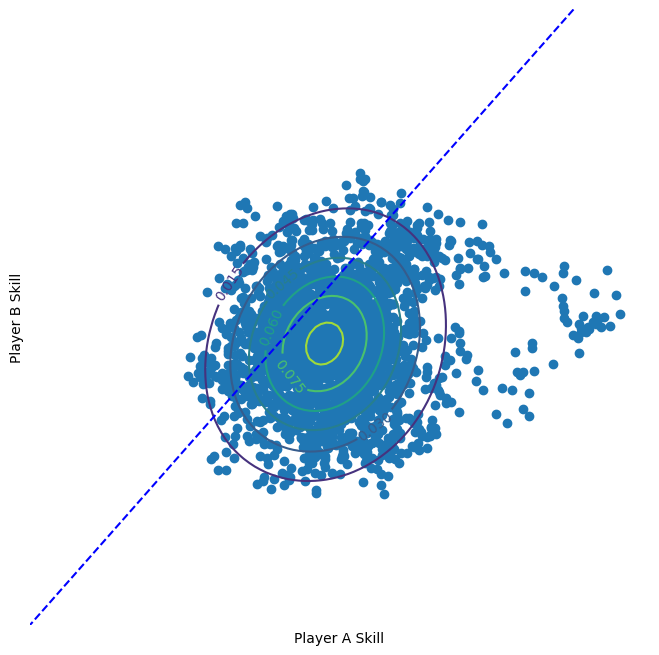

<Figure size 640x480 with 0 Axes>

In [11]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 2500
stepsize = 0.01

def log_posterior_a(zs):
  z1, z2 = zs[0], zs[1]
  return log_posterior_A_beat_B(z1, z2)

samples_a = draw_samples(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior_a)
plot_2d_fun(posterior_A_beat_B, "Player A Skill", "Player B Skill", samples_a)

Using samples generated by HMC, approximating the joint posterior where we observe player A winning 5 games against player B.

100%|██████████| 2500/2500 [01:20<00:00, 30.94it/s]


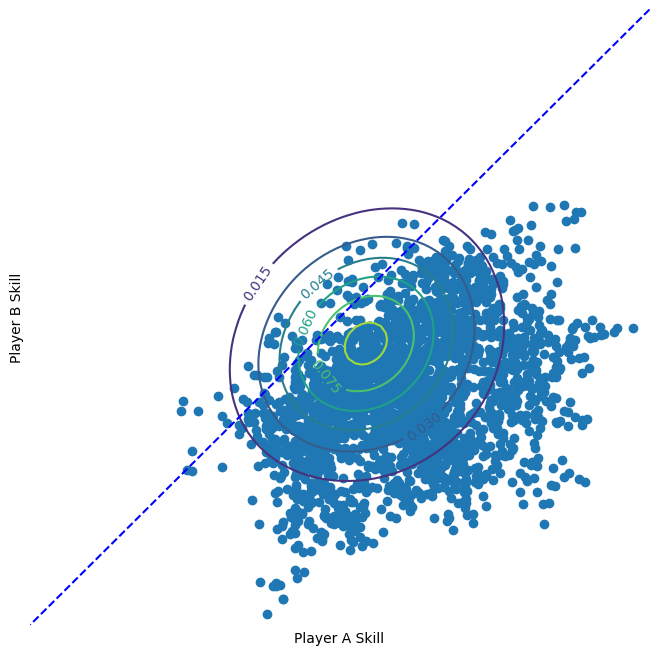

<Figure size 640x480 with 0 Axes>

In [12]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 2500
stepsize = 0.01
key = 42


def log_posterior_b(zs):
  return log_posterior_A_beat_B_5_times(zs[0], zs[1])

samples_b = draw_samples(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior_b)
plot_2d_fun(posterior_A_beat_B, "Player A Skill", "Player B Skill", samples_b)

Using samples generated by HMC, approximating the joint posterior where we observe player A winning 5 games and player B winning 5 games.

100%|██████████| 2500/2500 [01:35<00:00, 26.09it/s]


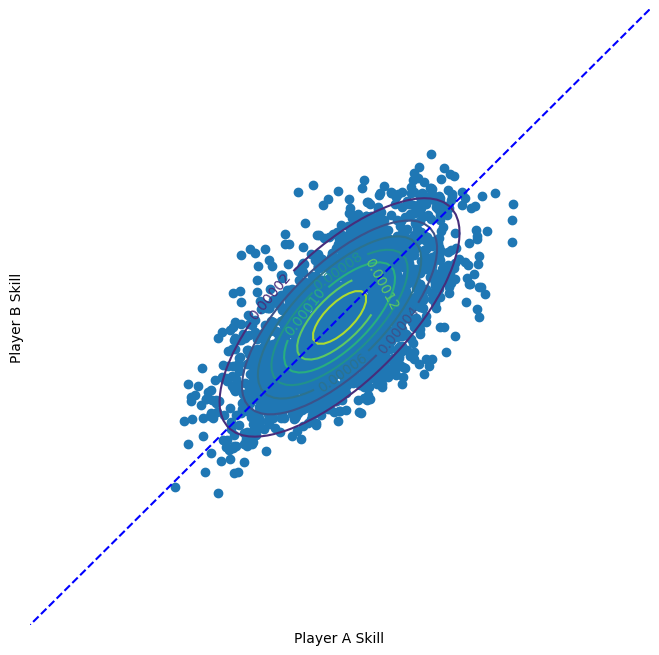

<Figure size 640x480 with 0 Axes>

In [13]:
# Hyperparameters
num_players = 2
num_leapfrog_steps = 20
n_samples = 2500
stepsize = 0.01


def log_posterior_c(zs):
  return log_posterior_beat_each_other_5_times(zs[0], zs[1])

samples_c = draw_samples(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior_c)
plot_2d_fun(posterior_beat_each_other_5_times, "Player A Skill", "Player B Skill", samples_c)

# Approximate inference conditioned on real data

The dataset contains data on 2546 chess games amongst 1434 players:
 - names is a 1163 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2543 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess

In [14]:
wget.download("https://vahidbalazadeh.me/assets/datasets/chess_players.csv")
wget.download("https://vahidbalazadeh.me/assets/datasets/chess_games.csv")
games = pd.read_csv("chess_games.csv")[["winner_id", "loser_id"]].to_numpy()
names = pd.read_csv("chess_players.csv")[["player_name"]].to_numpy().astype('str')

In [15]:
games = torch.LongTensor(games)

Assuming all game outcomes are i.i.d. conditioned on all players' skills, we are implementing a function $\texttt{log_games_likelihood}$ that takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihoods for all those observations given all the skills.



In [16]:
def log_games_likelihood(zs, games):
  # games is an array of size (num_games x 2)
  # zs is an array of size num_player

  winning_player_ixs = games[:,0]
  losing_player_ixs = games[:,1]
  winning_player_skills =  zs[winning_player_ixs]   #TODO: Look up the skill of the winning player in each game.
  losing_player_skills = zs[losing_player_ixs]    #TODO: Look up the skills of the losing player in each game.
  log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)         #TODO: Compute the log_likelihood of each game outcome.
  return torch.sum(log_likelihoods)   #TODO: Combine the log_likelihood of independent events.



Implementing a function $\texttt{joint_log_density}$ which combines the log-prior and log-likelihood of the observations to give $p(z_1, z_2, \dots, z_N, \text{all game outcomes})$

In [18]:
def log_joint_probability(zs, games):
  return log_joint_prior(zs) + log_games_likelihood(zs, games)

Running Hamiltonian Monte Carlo on the posterior over all skills conditioned on all the chess games from the dataset, for 10000 samples.

In [19]:
# Hyperparameters
num_players = 1163
num_leapfrog_steps = 20
n_samples = 10000
stepsize = 0.01

def log_posterior(zs):
    return log_joint_probability(zs, games)

all_games_samples = draw_samples(num_players, stepsize, num_leapfrog_steps, n_samples, log_posterior)

100%|██████████| 10000/10000 [06:34<00:00, 25.37it/s]


Based on our samples from the previous question, we'll plot the approximate mean and variance of the marginal skill of each player, sorted by average skill.

<ErrorbarContainer object of 3 artists>

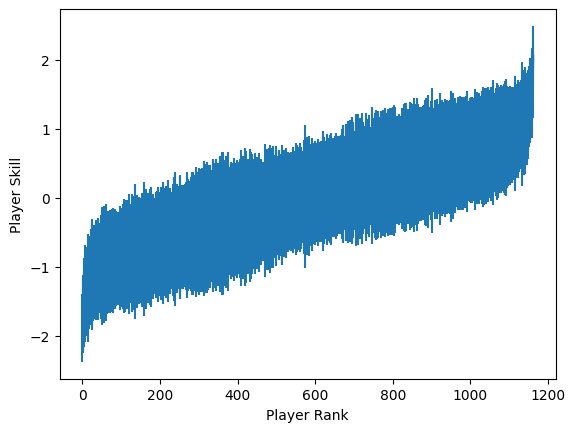

In [20]:
mean_skills = torch.mean(all_games_samples, dim=0)
var_skills = torch.var(all_games_samples, dim=0)

order = np.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(num_players), mean_skills[order], var_skills[order])

In [21]:
print(f"Bottom 5: {[names[int(i)][0] for i in list(order)[0:5]]}")



print(f"Top 5: {[names[int(i)][0] for i in list(order)[-5:]]}")


Bottom 5: ['josephelbouhessaini', 'vkmansftw', 'italiantranslator', 'thebestofthebad', 'kylarr']
Top 5: ['projetoxadrez', 'chesswithmom', 'smartduckduckcow', 'mrzoom47', 'doraemon61']
